<img src="https://c9k9c9v3.stackpathcdn.com/wp-content/uploads/2018/04/PH-mobile-payment-providers-go-into-acceleration-mode-1440x564_c.jpg?x82653">

### Context

There is a lack of public available datasets on financial services and specially in the emerging mobile money transactions domain. Financial datasets are important to many researchers and in particular to us performing research in the domain of fraud detection. Part of the problem is the intrinsically private nature of financial transactions, that leads to no publicly available datasets.

We present a synthetic dataset generated using the simulator called PaySim as an approach to such a problem. PaySim uses aggregated data from the private dataset to generate a synthetic dataset that resembles the normal operation of transactions and injects malicious behaviour to later evaluate the performance of fraud detection methods.

### Objective

1. To gain knowledge how fraud transactions are classified
2. To try different techniques to improve model



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
%matplotlib inline

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import Perceptron
from sklearn.tree import DecisionTreeClassifier

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [2]:
df = pd.read_csv('PS_20174392719_1491204439457_log.csv', nrows=90_000)
df

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0,0
...,...,...,...,...,...,...,...,...,...,...,...
89995,10,PAYMENT,15365.90,C2142225413,354430.00,339064.10,M2046928025,0.00,0.00,0,0
89996,10,PAYMENT,6593.32,C1100408158,147849.00,141255.68,M1301761451,0.00,0.00,0,0
89997,10,DEBIT,2690.61,C1285105648,80975.00,78284.39,C961113212,839678.62,842369.23,0,0
89998,10,PAYMENT,9532.06,C1003190166,11302.00,1769.94,M1300351396,0.00,0.00,0,0


**Sample Row**

1 | PAYMENT | 1060.31 | C429214117 | 1089.0 | 28.69 | M1591654462 | 0.0 | 0.0 | 0 | 0


**Brief Description of each column**

1. **step** - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).

2. **type** - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.

3. **amount** - amount of the transaction in local currency.

4. **nameOrig** - customer who started the transaction

5. **oldbalanceOrg** - initial balance before the transaction

6. **newbalanceOrig** - new balance after the transaction

7. **nameDest** - customer who is the recipient of the transaction

8. **oldbalanceDest** - initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).

9. **newbalanceDest** - new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).

10. **isFraud** - This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.

11. **isFlaggedFraud** - The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200,000 in a single transaction.

### **I. Exploratory Data Analysis**

#### **Column Information**

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90000 entries, 0 to 89999
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   step            90000 non-null  int64  
 1   type            90000 non-null  object 
 2   amount          90000 non-null  float64
 3   nameOrig        90000 non-null  object 
 4   oldbalanceOrg   90000 non-null  float64
 5   newbalanceOrig  90000 non-null  float64
 6   nameDest        90000 non-null  object 
 7   oldbalanceDest  90000 non-null  float64
 8   newbalanceDest  90000 non-null  float64
 9   isFraud         90000 non-null  int64  
 10  isFlaggedFraud  90000 non-null  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 7.6+ MB


Based from this info, we could separate the column into:

- **Numerical**: step, amount, oldlbalanceOrig, newbalanceOrig, oldbalanceDest, newbalanceDest

- **Categorical**: type, nameOrig, nameDest, isFlaggedFraud

#### **Checking for rows with missing values**

In [4]:
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

The data doesn't have missing values

#### **Transaction Type**

[Text(0.5, 1.0, 'Payment Type Distribution')]

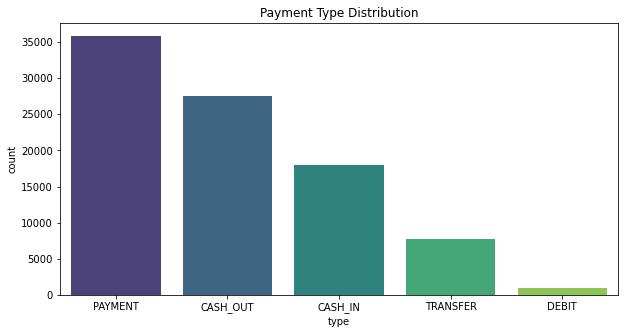

In [5]:
plt.figure(figsize=(10,5))
sns.countplot(
    x = 'type', 
    data = df, 
    palette = 'viridis',
    order = df['type'].value_counts().index
).set(title='Payment Type Distribution')

[Text(0.5, 1.0, 'Fraud Payments per Payment Type Distribution')]

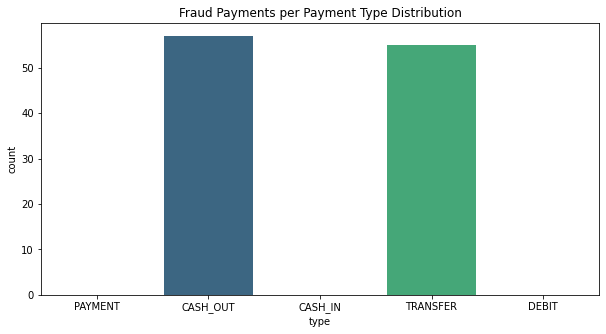

In [6]:
isFraud_df = df[df.isFraud == True]
notFraud_df = df[df.isFraud == False]

plt.figure(figsize=(10,5))
sns.countplot(
    x = 'type', 
    data = isFraud_df, 
    palette = 'viridis',
    order = df['type'].value_counts().index
).set(title='Fraud Payments per Payment Type Distribution')

Insights
- The most common transaction used is **Payment** (Customer to Merchants)
- The plot shows that **fraud** transactions usually occurs on **cash out** and **transfer** transactions. 
- The act of removing the money from an account by transferring it to another account and then cashing out that money from the system is a potential fraud transaction.

#### **Transaction Amount**

Text(0.5, 1.0, 'Not Fraud Payments')

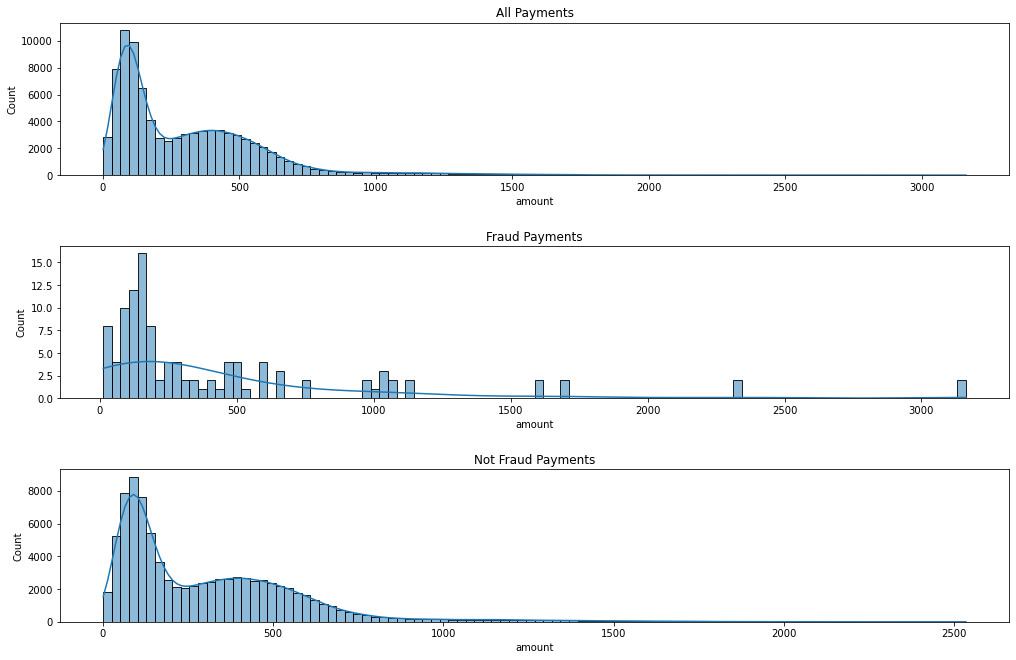

In [7]:
fig, axes = plt.subplots(3, 1, figsize=(15, 10))
fig.tight_layout(pad=5)

transform = np.sqrt(df['amount'] + 1)
sns.histplot(ax=axes[0],data=df, x=transform, kde=True, bins=100).set_title('All Payments')

transform = np.sqrt(isFraud_df['amount'] + 1)
sns.histplot(ax=axes[1],data=isFraud_df, x=transform, kde=True, bins=100).set_title('Fraud Payments')

transform = np.sqrt(notFraud_df['amount'] + 1)
sns.histplot(ax=axes[2],data=notFraud_df, x=transform, kde=True, bins=100).set_title('Not Fraud Payments')

In [8]:
pd.concat([
    df.amount.describe().apply(lambda x: format(x, 'f')),
    isFraud_df.amount.describe().apply(lambda x: format(x, 'f')),
    notFraud_df.amount.describe().apply(lambda x: format(x, 'f'))
], keys=['All', 'Fraud', 'Not Fraud'], axis = 1)

,All,Fraud,Not Fraud
count,90000.000000,112.000000,89888.000000
mean,170090.264532,550255.927857,169616.580010
std,338576.688242,1561291.464092,334045.674980
min,0.320000,164.000000,0.320000
25%,9723.960000,16671.960000,9714.122500
50%,50518.550000,34198.245000,50540.800000
75%,208076.402500,266318.625000,208007.807500
max,10000000.000000,10000000.000000,6419835.270000


Key Takeaways:
- There is a huge margin on the amount being paid in every transaction. This can be transform and normalize later on. 
- The max transaction amount made reached 10,000,000, which is labeled as Fraud.
- The minimum fraud transaction amount is 181. This invalidates the assumption that fraud transactions are usually high in amount.

#### **Origin and Destination Balance**

<AxesSubplot:xlabel='newbalanceDest', ylabel='Count'>

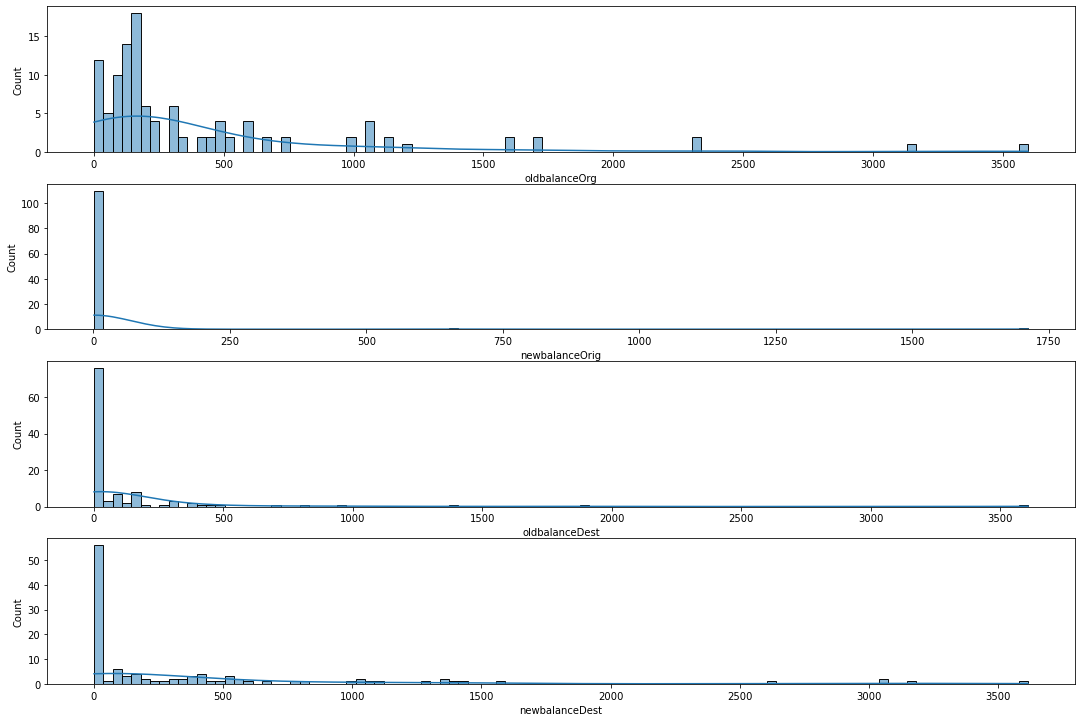

In [9]:
fig, axes = plt.subplots(4, 1, figsize=(15, 10))
fig.tight_layout()

transform = np.sqrt(isFraud_df['oldbalanceOrg'] + 1)
sns.histplot(ax=axes[0],data=isFraud_df, x=transform, kde=True, bins=100)

transform = np.sqrt(isFraud_df['newbalanceOrig'] + 1)
sns.histplot(ax=axes[1],data=isFraud_df, x=transform, kde=True, bins=100)

transform = np.sqrt(isFraud_df['oldbalanceDest'] + 1)
sns.histplot(ax=axes[2],data=isFraud_df, x=transform, kde=True, bins=100)

transform = np.sqrt(isFraud_df['newbalanceDest'] + 1)
sns.histplot(ax=axes[3],data=isFraud_df, x=transform, kde=True, bins=100)

<AxesSubplot:xlabel='newbalanceDest', ylabel='Count'>

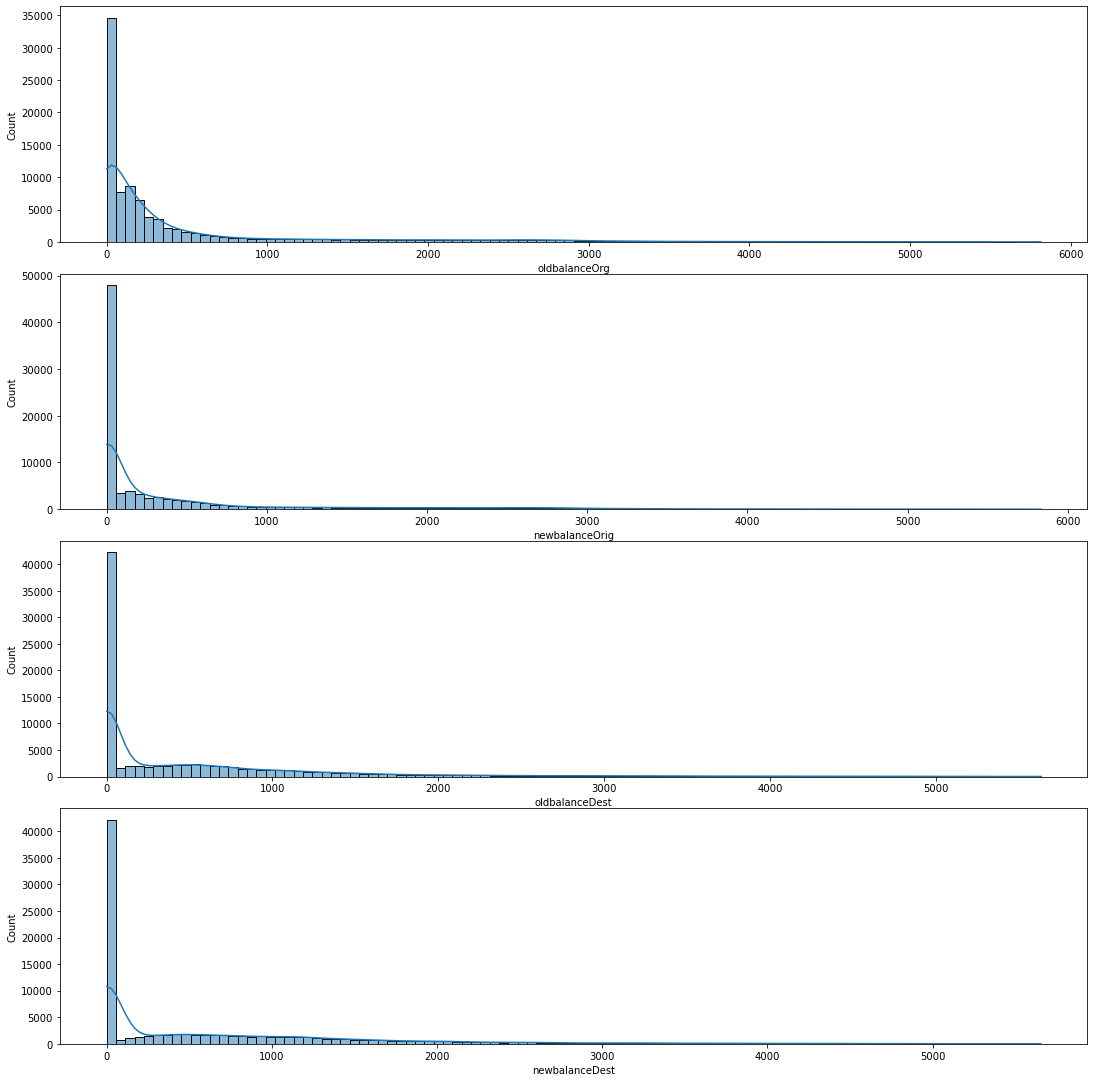

In [10]:
fig, axes = plt.subplots(4, 1, figsize=(15, 15))
fig.tight_layout()

transform = np.sqrt(notFraud_df['oldbalanceOrg'] + 1)
sns.histplot(ax=axes[0],data=notFraud_df, x=transform, kde=True, bins=100)

transform = np.sqrt(notFraud_df['newbalanceOrig'] + 1)
sns.histplot(ax=axes[1],data=notFraud_df, x=transform, kde=True, bins=100)

transform = np.sqrt(notFraud_df['oldbalanceDest'] + 1)
sns.histplot(ax=axes[2],data=notFraud_df, x=transform, kde=True, bins=100)

transform = np.sqrt(notFraud_df['newbalanceDest'] + 1)
sns.histplot(ax=axes[3],data=notFraud_df, x=transform, kde=True, bins=100)

#### **Sender and Receiver Account Names (nameOrig and nameDest)**

**Assumptions**
1. Sender can't send money to itself!
2. Since fraud payments occurs only on Cashout and Transfer transactions, most, if not all transaction should be from customer to customer.
3. *"In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system."* Based from this statement, recipients of fraud transfers must be on sender of fraud cashouts.


In [11]:
print("Does same sender and receiver in a transaction possible?")
print(df[df.nameOrig == df.nameDest].value_counts().any())

Does same sender and receiver in a transaction possible?
False


In [12]:
senders = df['nameOrig'].astype(str).str[0].unique()
receivers = df['nameDest'].astype(str).str[0].unique()
fraud_senders = isFraud_df['nameOrig'].astype(str).str[0].unique()
fraud_receivers = isFraud_df['nameDest'].astype(str).str[0].unique()

print(f'Sender Types: {senders}')
print(f'Receiver Types: {receivers}')
print(f'Senders of fraud transactions: {fraud_senders}')
print(f'Receivers of fraud transactions: {fraud_receivers}')

Sender Types: ['C']
Receiver Types: ['M' 'C']
Senders of fraud transactions: ['C']
Receivers of fraud transactions: ['C']


In [13]:
pay_type = isFraud_df.type.unique() # ['TRANSFER', 'CASH_OUT']
fraud_transfer = isFraud_df[isFraud_df.type == pay_type[0]]
fraud_cashout = isFraud_df[isFraud_df.type == pay_type[1]]

print('Does a receiver of fraud transfer showed up in sender of fraud cashout?')
print(fraud_transfer.nameDest.isin(fraud_cashout.nameOrig).any())

Does a receiver of fraud transfer showed up in sender of fraud cashout?
False


**Conclusion**
- The dataset doesn't have a row with same nameDest and nameOrig, which can be an outlier.
- Rows with receiver type 'M' can be ruled out as non fraudulent transactions. 

#### **Flagged as Fraud Transactions**

Let's check the correlation between the isFlaggedFraud and isFraud column

In [14]:
corr_mat = df[['isFraud', 'isFlaggedFraud']].corr()
corr_mat

,isFraud,isFlaggedFraud
isFraud,1.0,NaN
isFlaggedFraud,NaN,NaN


In [15]:
print("Fraud transactions by type: \n",df.isFlaggedFraud.value_counts())

Fraud transactions by type: 
 0    90000
Name: isFlaggedFraud, dtype: int64


Since isFlaggedFraud column indicates that all transactions are not fraud, this will not be useful as a feature for the model.

#### **Target: isFraud**

In [16]:
col = df['isFraud']
unique_counts = col.value_counts()
relative_freq = col.value_counts(normalize=True)
percentage = relative_freq.mul(100).round(1).astype(str) + '%'
pd.DataFrame({'counts': unique_counts, 'freq': relative_freq, 'percentage': percentage})

,counts,freq,percentage
0,89888,0.998756,99.9%
1,112,0.001244,0.1%


### **II. Feature Engineering and Selection**

#### **One Hot Encoding**

In [17]:
type_df = pd.get_dummies(df.type, prefix='type')

if ~type_df.columns.isin(df.columns).any():
    df = pd.concat([df, type_df], axis=1)
    
df

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,0,0,0,0,1,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,0,0,0,0,1,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0,0,0,0,0,1
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,0,0,1,0,0,0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89995,10,PAYMENT,15365.90,C2142225413,354430.00,339064.10,M2046928025,0.00,0.00,0,0,0,0,0,1,0
89996,10,PAYMENT,6593.32,C1100408158,147849.00,141255.68,M1301761451,0.00,0.00,0,0,0,0,0,1,0
89997,10,DEBIT,2690.61,C1285105648,80975.00,78284.39,C961113212,839678.62,842369.23,0,0,0,0,1,0,0
89998,10,PAYMENT,9532.06,C1003190166,11302.00,1769.94,M1300351396,0.00,0.00,0,0,0,0,0,1,0


#### **Cutting Out Unnecessary Columns**

In [18]:
feat_drop = ['step', 'type', 'nameOrig', 'nameDest', 'isFlaggedFraud']
df.drop(feat_drop, axis=1, inplace=True)

#### **Correlation**

<AxesSubplot:>

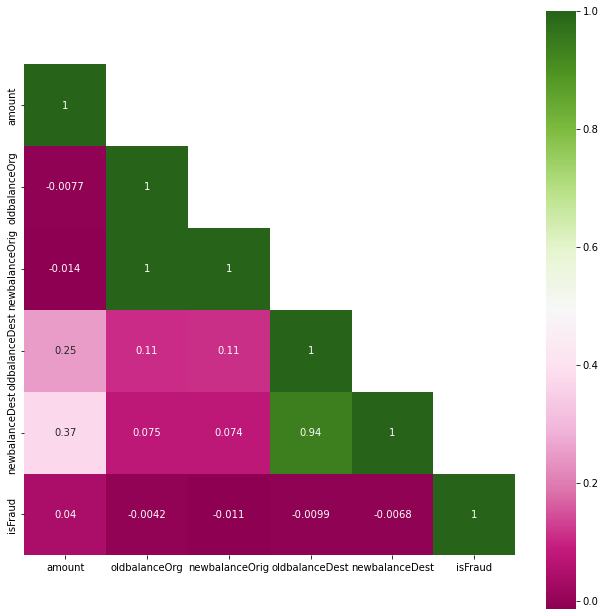

In [19]:
corr_mat = df[df.columns[0:6]].corr('pearson')
mask = np.triu(corr_mat, 1)
plt.figure(figsize=(11,11))
sns.heatmap(corr_mat, cmap='PiYG', annot=True, square=True, mask=mask)

<AxesSubplot:>

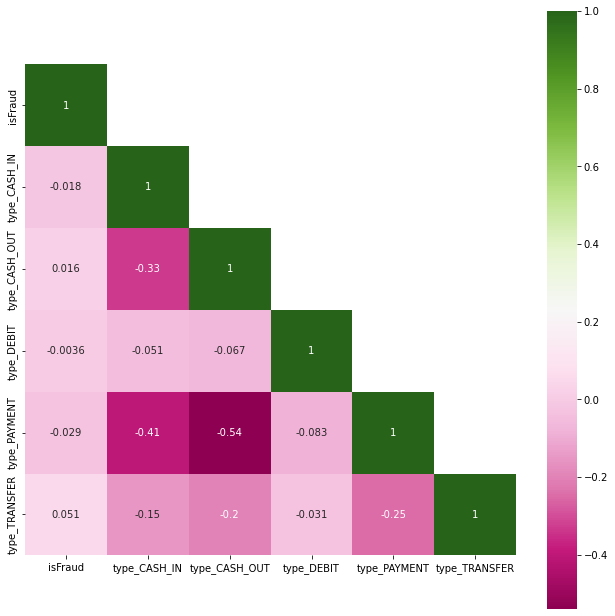

In [20]:
corr_mat = df[df.columns[5:11]].corr('pearson')
mask = np.triu(corr_mat, 1)
plt.figure(figsize=(11,11))
sns.heatmap(corr_mat, cmap='PiYG', annot=True, square=True, mask=mask)

#### **Train Test Split**

In [21]:
X = df.drop(['isFraud'], axis=1)
y = df.isFraud

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42
)

### **III. Building ML Model**

In [22]:
from sklearn import preprocessing

# ML Classifier Objects
log_reg_clf = LogisticRegression(solver='liblinear', max_iter=1000)
nb_clf = GaussianNB()
knn_clf = KNeighborsClassifier()
prcptrn_clf = Perceptron()
dt_clf=DecisionTreeClassifier()

# ML Classifier Dictionary
clf_dict = {
    'Logistic Regression': log_reg_clf, 
    'Naive Bayes': nb_clf,
    'KNN': knn_clf,
    'Perceptron': prcptrn_clf,
    'Decision Tree': dt_clf
}


def get_model_performances(X_train, y_train):
    log_reg_clf = LogisticRegression(solver='liblinear', max_iter=1000)
    nb_clf = GaussianNB()
    knn_clf = KNeighborsClassifier()
    prcptrn_clf = Perceptron()
    dt_clf=DecisionTreeClassifier()

    clf_dict = {
        'Logistic Regression': log_reg_clf, 
        'Naive Bayes': nb_clf,
        'KNN': knn_clf,
        'Perceptron': prcptrn_clf,
        'Decision Tree': dt_clf
    }

    model_acc = []
    for model in clf_dict.keys():
        y_pred = clf_dict[model].fit(X_train, y_train).predict(X_test)
        test_accuracy = metrics.accuracy_score(y_test, y_pred) * 100
        test_precision = metrics.precision_score(y_test, y_pred, zero_division=1) * 100
        test_recall = metrics.recall_score(y_test, y_pred, zero_division=1) * 100

        model_acc.append({
            'model': model, 
            'test_accuracy': test_accuracy, 
            'test_precision': test_precision,
            'test_recall': test_recall,
        })
        print(model)
        print(confusion_matrix(y_test, y_pred))

    return pd.DataFrame(model_acc).sort_values(by='test_recall', ascending=False)

In [23]:
get_model_performances(X_train, y_train)

Logistic Regression
[[26944    19]
 [    3    34]]
Naive Bayes
[[26523   440]
 [   34     3]]
KNN
[[26962     1]
 [   34     3]]
Perceptron
[[26519   444]
 [   15    22]]
Decision Tree
[[26949    14]
 [   12    25]]


,model,test_accuracy,test_precision,test_recall
0,Logistic Regression,99.918519,64.150943,91.891892
4,Decision Tree,99.903704,64.102564,67.567568
3,Perceptron,98.300000,4.721030,59.459459
1,Naive Bayes,98.244444,0.677201,8.108108
2,KNN,99.870370,75.000000,8.108108


The precision is the ratio tp / (tp + fp) where tp is the number of true positives and fp the number of false positives. The precision is intuitively the ability of the classifier not to label as positive a sample that is negative.

The recall is the ratio tp / (tp + fn) where tp is the number of true positives and fn the number of false negatives. The recall is intuitively the ability of the classifier to find all the positive samples.


#### **Balancing Data**

https://developers.google.com/machine-learning/data-prep/construct/sampling-splitting/imbalanced-data

In [24]:
Xy_train = pd.concat([X_train, y_train], axis=1)
Xy_train['isFraud'].value_counts()

0    62925
1       75
Name: isFraud, dtype: int64

In [25]:
from sklearn.utils import resample

majority = Xy_train[Xy_train['isFraud'] == 0]
minority = Xy_train[Xy_train['isFraud'] == 1]

minority_upsampled = resample(
    minority,
    replace = True,
    n_samples = len(majority),
    random_state = 42
)
Xy_train_balanced = pd.concat([majority, minority_upsampled], ignore_index=True)
Xy_train_balanced['isFraud'].value_counts()

0    62925
1    62925
Name: isFraud, dtype: int64

In [26]:
X_train_balanced = Xy_train_balanced.drop('isFraud', axis=1)
y_train_balanced = Xy_train_balanced['isFraud']

In [ ]:
get_model_performances(X_train_balanced, y_train_balanced)

Logistic Regression
[[23922  3041]
 [    2    35]]
Naive Bayes
[[ 5873 21090]
 [    0    37]]
KNN
[[26903    60]
 [   25    12]]
Perceptron
[[16726 10237]
 [    2    35]]
Decision Tree
[[26952    11]
 [   13    24]]


,model,test_accuracy,test_precision,test_recall
1,Naive Bayes,21.888889,0.175131,100.000000
0,Logistic Regression,88.729630,1.137841,94.594595
3,Perceptron,62.077778,0.340732,94.594595
4,Decision Tree,99.911111,68.571429,64.864865
2,KNN,99.685185,16.666667,32.432432


Based from the results, Naive Bayes indeed got the highest recall. However, it has low accuracy and if ever used in a real world environment, it will cause real headache for the personnels who handles false positive cases of fraud transactions. Thus, it would be better to used Logistic Regression, with the second highest recall of 94.6% and having fair accuracy of 88.7%.